In [81]:
##################################################################################################################################
#                                                                                                                                #
#                         A FRAMEWORK FOR EXPLAINABLE AI FOR SATELLITE NETWORKS ANOMALY DETECTION                                #
#                                                                                                                                #
#                                                                                                                                #
#                                              *******   SLA Breach   *******                                                    #
#                                                                                                                                #
#                                                                                                                                #
#                                                    University of Hull                                                          #
#                                                MSc Artificial Intelligence                                                     #
#                                                                                                                                #
#                                                      Amadiz Sabino                                                             #
#                                                                                                                                #
##################################################################################################################################

In [82]:
# 1) ENV & DATA ACCESS
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Mount Google Drive
#   - Define DATA_DIR where raw files and artifacts will live (separate from other use cases)
#   - Quick sanity print of folder contents
# -------------------------------------------------------------------------------------------------

import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATA_DIR = "/content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses"
ART_DIR  = os.path.join(DATA_DIR, "artifacts_sla")
os.makedirs(ART_DIR, exist_ok=True)

!ls "$DATA_DIR"



Mounted at /content/drive
3_3_SES_Prototype_SignalLoss.ipynb  artifacts_sla
3_3_SES_Prototype_SLA_Proxy.ipynb   CIEL2_ManeuverEvents_R1.csv
Archive				    ses_clean_10s.parquet
artifacts_signal_loss		    SESGroundData_Oct-Nov_AS1.xlsx


In [83]:
# 2) Import Initial Librarires
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Install & import core libs used throughout the notebook
#   - Keep dependencies consistent with Signal Loss notebook
# -------------------------------------------------------------------------------------------------
!pip -q install pandas numpy scikit-learn xgboost matplotlib

import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier


In [84]:
# 3) LOAD SES DATA
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Load the data (same file source as Signal Loss)
#   - Ensure strictly increasing datetime index
#   - In cases timestamp column is named differently, we auto-detect
# -------------------------------------------------------------------------------------------------

path = os.path.join(DATA_DIR, "SESGroundData_Oct-Nov_AS1.xlsx")
df = pd.read_excel(path, sheet_name=0)

# Format sheet:
if df.iloc[0].isna().sum() < 5:
    df.columns = df.iloc[0]
    df = df.drop(index=0).reset_index(drop=True)

time_col = "_time" if "_time" in df.columns else "timestamp"
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.set_index(time_col).sort_index()
df = df[~df.index.duplicated(keep="last")]

print("Time span:", df.index.min(), "->", df.index.max(), "| rows:", len(df))
df.head(3)


Time span: 2021-10-18 07:25:10+00:00 -> 2021-11-30 23:59:50+00:00 | rows: 377489


,ANT_1_ACU,ANT_2_ACU,ANT_3_ACU,ANT_4_ACU,MODEM__10_IN,MODEM__10_OUT,MODEM__11_IN,MODEM__11_OUT,MODEM__14_IN,MODEM__14_OUT,...,MODEM__3_OUT,MODEM__4_IN,MODEM__4_OUT,MODEM__5_IN,MODEM__5_OUT,MODEM__8_IN,MODEM__8_OUT,MODEM__9_IN,MODEM__9_OUT,Spacecraft
_time,,,,,,,,,,,,,,,,,,,,,
2021-10-18 07:25:10+00:00,NaN,NaN,NaN,NaN,9.725,13.025,11.9000,12.1667,11.1000,18.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-18 07:25:20+00:00,NaN,NaN,NaN,NaN,10.650,12.975,11.7500,12.1000,11.1500,18.225,...,NaN,15.100,NaN,19.0333,20.0000,14.200,19.4,11.0333,14.4000,M010
2021-10-18 07:25:30+00:00,NaN,22.1649,NaN,NaN,9.900,12.800,11.8333,12.1000,11.0667,18.250,...,NaN,15.275,20.6,19.0000,20.1333,14.175,19.3,10.9750,14.3333,M010


In [85]:
# 4) Data Preparation
# CLEAN -> RESAMPLE -> CLIP -> CONTEXT
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Numeric coercion
#   - Drop near-constant & super-sparse columns
#   - Resample to 10s cadence + limited ffill
#   - Robust clipping of extreme tails to de-glitch
#   - Maneuver mask integration
# -------------------------------------------------------------------------------------------------

# 4A) Coerce numerics
num_df = df.copy()
for c in num_df.columns:
    if num_df[c].dtype == "object":
        num_df[c] = pd.to_numeric(num_df[c], errors="coerce")

def is_near_constant(s, tol=1e-9):
    s = s.dropna()
    return (s.max() - s.min()) <= tol

near_const = [c for c in num_df.columns if pd.api.types.is_numeric_dtype(num_df[c]) and is_near_constant(num_df[c])]
num_df = num_df.drop(columns=near_const)

# 4B) Drop sparse columns (>30% missing)
missing_pct = num_df.isna().mean()
sparse_cols = missing_pct[missing_pct > 0.30].index.tolist()
num_df = num_df.drop(columns=sparse_cols)

# 4C) Resample to 10s with short ffill (≤20s)
res = num_df.resample("10s").last().ffill(limit=2)

# 4D) Robust clipping
q_low, q_high = res.quantile(0.005), res.quantile(0.995)
res = res.clip(lower=q_low, upper=q_high, axis=1)

# 4E) Optional maneuver mask (same as Signal Loss, safe if file missing)
man_path = os.path.join(DATA_DIR, "CIEL2_ManeuverEvents_R1.csv")
maneuver_mask = pd.Series(False, index=res.index)
if os.path.exists(man_path):
    man = pd.read_csv(man_path, header=None, names=["StartTime","EndTime","EventType"])
    tz = res.index.tz
    man["StartTime"] = pd.to_datetime(man["StartTime"], errors="coerce")
    man["EndTime"]   = pd.to_datetime(man["EndTime"], errors="coerce")
    if tz is not None:
        man["StartTime"] = man["StartTime"].dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")
        man["EndTime"]   = man["EndTime"].dt.tz_localize(tz, nonexistent="shift_forward", ambiguous="NaT")

    idx = res.index
    for s, e in zip(man["StartTime"], man["EndTime"]):
        if pd.isna(s) or pd.isna(e):
            continue
        s_clip, e_clip = max(s, idx[0]), min(e, idx[-1])
        if s_clip <= e_clip:
            maneuver_mask.loc[s_clip:e_clip] = True

    pad = pd.Timedelta(minutes=2)
    steps = int(pad.total_seconds()/10)
    padded = maneuver_mask.copy()
    padded |= maneuver_mask.shift(+steps, fill_value=False)
    padded |= maneuver_mask.shift(-steps, fill_value=False)
    maneuver_mask = maneuver_mask | padded
else:
    print("WARNING: Maneuver file not found:", man_path)

res = res.assign(in_maneuver = maneuver_mask.astype(int))
print("Resampled shape:", res.shape, "| maneuver fraction:", maneuver_mask.mean().round(3))


Resampled shape: (377489, 29) | maneuver fraction: 0.0


In [86]:
# 5A - KPI DISCOVERY (Throughput proxy from MODEM *_OUT) + NORMALIZATION
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Your file has no explicit RTT/LAT/LOSS columns; it *does* have many MODEM__##_OUT values.
#   - We create a robust THROUGHPUT proxy by aggregating *_OUT channels (sum or robust mean).
#   - LATENCY and LOSS remain unavailable (None) and are simply not used in SLA checks.
#   - If later you get real RTT/LOSS columns, set MANUAL_MAP below and re-run.
# -------------------------------------------------------------------------------------------------

import re


# OPTIONAL manual overrides if you later get true KPI columns:
MANUAL_MAP = {
    # "throughput": "YOUR_TRUE_THROUGHPUT_COLUMN",  # leave empty now
    # "latency":    "YOUR_RTT_MS_COLUMN",
    # "loss_pct":   "YOUR_PACKET_LOSS_PERCENT_COLUMN"
}

all_cols = list(res.columns)
num_cols = [c for c in all_cols if pd.api.types.is_numeric_dtype(res[c])]

# 5A — Try genuine manual map first
kpi_cols = {"throughput": None, "latency": None, "loss_pct": None}
for k in list(kpi_cols.keys()):
    v = MANUAL_MAP.get(k)
    if v and v in res.columns:
        kpi_cols[k] = v

# 5B — If no real THROUGHPUT provided, build a proxy from MODEM *_OUT
if kpi_cols["throughput"] is None:
    out_cols = [c for c in num_cols if re.search(r'_out$', c, flags=re.IGNORECASE)]
    if len(out_cols) == 0:
        # fallback: use all numeric modem columns
        modem_cols = [c for c in num_cols if c.startswith("MODEM__")]
        out_cols = modem_cols

    if len(out_cols) == 0:
        raise ValueError("No usable modem columns found to build a throughput proxy.")

    # choose one of the two aggregations (sum gives volume feeling; robust_mean reduces channel bias)
    agg_mode = "sum"            # or "robust_mean"
    if agg_mode == "sum":
        thr_proxy = res[out_cols].clip(lower=0).sum(axis=1)
    else:
        thr_proxy = res[out_cols].clip(lower=0).median(axis=1)

    thr_name = "__THROUGHPUT_PROXY_Mbps"
    res[thr_name] = thr_proxy
    kpi_cols["throughput"] = thr_name

# 5C — We don’t have RTT/LAT/LOSS in this dataset → keep None
# kpi_cols["latency"]  = kpi_cols["latency"]  # stays None
# kpi_cols["loss_pct"] = kpi_cols["loss_pct"] # stays None

present_kpis = {k:v for k,v in kpi_cols.items() if v is not None}
print("KPI columns (using proxy where needed):", kpi_cols)

# 5D — Build KPI frame for downstream SLA logic
keep_cols = list(present_kpis.values())
if "in_maneuver" in res.columns:
    keep_cols += ["in_maneuver"]
kpi_frame = res[keep_cols].copy()

# 5E — Unit normalization
# - Throughput proxy is already in "relative Mbps-like units" (sum of channels). You can rescale if desired.
#   Example: kpi_frame[thr_name] = kpi_frame[thr_name] / 10.0
for key, col in present_kpis.items():
    s = kpi_frame[col].describe()[['mean','std','min','max']].round(3)
    print(f"  {key.upper():>10} -> {col}: {dict(s)}")

kpi_frame.head(3)
# Persist KPI column mapping (for auditability / reproducibility)
with open(os.path.join(ART_DIR, "kpi_columns.json"), "w") as f:
    json.dump(kpi_cols, f, indent=2)
print("Saved:", os.path.join(ART_DIR, "kpi_columns.json"))



KPI columns (using proxy where needed): {'throughput': '__THROUGHPUT_PROXY_Mbps', 'latency': None, 'loss_pct': None}
  THROUGHPUT -> __THROUGHPUT_PROXY_Mbps: {'mean': np.float64(221.02), 'std': np.float64(12.117), 'min': np.float64(0.0), 'max': np.float64(258.617)}
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/kpi_columns.json


In [87]:
# 5B - ADAPTIVE SLA THRESHOLDS (TRAIN-ONLY) + EARLY WARNING FLAGS
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Learn SLA thresholds *only* from TRAIN (first 60%) to avoid leakage.
#   - If a KPI is "higher is better" (THROUGHPUT): breach if value < τ_SLA (e.g., p10 of TRAIN).
#   - If a KPI is "lower is better" (LATENCY/LOSS): breach if value > τ_SLA (e.g., p90 of TRAIN).
#   - Provide EARLY WARNING thresholds (p20 for throughput; p80 for latency/loss).
#   - Produce boolean time-series on the TEST slice: <kpi>_warn, <kpi>_breach, plus OR-of-any flags.
#   - Optionally mask out maneuver periods (allowed downtimes).
#
# Inputs expected:
#   - split1, split2 (train/val/test cut points) already defined like in your signal loss notebook
#   - kpi_cols: dict with keys in {"throughput","latency","loss_pct"} -> column name or None
#   - kpi_frame: DataFrame containing the present KPI columns (+ optional 'in_maneuver')
# -------------------------------------------------------------------------------------------------

# 5A — DEFINE TRAIN / VAL / TEST SPLITS (60/20/20) FOR KPI FRAME
# -------------------------------------------------------------------------------------------------
# Purpose:
#   Create split markers consistent with Signal Loss notebook, but tied to `kpi_frame`.
#   These are used by the SLA thresholding to learn only from TRAIN and then build flags on TEST without leakage.
# -------------------------------------------------------------------------------------------------

assert 'kpi_frame' in globals(), "kpi_frame must be created before splitting."

n = len(kpi_frame)
split1 = int(n * 0.60)   # TRAIN: first 60%
split2 = int(n * 0.80)   # VAL:   next 20% (60..80%), TEST: last 20% (80..100%)

idx_train = kpi_frame.index[:split1]
idx_val   = kpi_frame.index[split1:split2]
idx_test  = kpi_frame.index[split2:]

print(f"Rows: {n} | TRAIN={len(idx_train)} | VAL={len(idx_val)} | TEST={len(idx_test)}")
print(f"TRAIN: {idx_train[0]} → {idx_train[-1]}")
print(f"VAL  : {idx_val[0]} → {idx_val[-1]}")
print(f"TEST : {idx_test[0]} → {idx_test[-1]}")

assert 'kpi_cols' in globals() and 'kpi_frame' in globals()
assert 'split1' in globals() and 'split2' in globals()

# 5B.1 — Define KPI direction metadata
# - 'throughput' : higher is better  -> use lower percentiles for thresholds (p10 SLA / p20 warn)
# - 'latency'    : lower is better   -> use upper percentiles (p90 SLA / p80 warn)
# - 'loss_pct'   : lower is better   -> use upper percentiles (p90 SLA / p80 warn)
KPI_META = {
    "throughput": {"direction": "higher_better", "warn_pct": 20, "sla_pct": 10},
    "latency":    {"direction": "lower_better",  "warn_pct": 80, "sla_pct": 90},
    "loss_pct":   {"direction": "lower_better",  "warn_pct": 80, "sla_pct": 90},
}

present = {k:v for k,v in kpi_cols.items() if v is not None}
if not present:
    raise ValueError("No KPI columns available (even the throughput proxy). Check the KPI discovery cell.")

# 5B.2 — Compute thresholds from TRAIN only (index [:split1])
SLA_THRESH = {}
for k, col in present.items():
    meta = KPI_META[k]
    s_train = kpi_frame[col].iloc[:split1]

    if meta["direction"] == "higher_better":
        warn_thr = float(np.nanpercentile(s_train, meta["warn_pct"]))
        sla_thr  = float(np.nanpercentile(s_train, meta["sla_pct"]))
        comp     = "lt"  # warn/breach when value < threshold
    else:
        warn_thr = float(np.nanpercentile(s_train, meta["warn_pct"]))
        sla_thr  = float(np.nanpercentile(s_train, meta["sla_pct"]))
        comp     = "gt"  # warn/breach when value > threshold

    SLA_THRESH[k] = {
        "column": col,
        "direction": meta["direction"],
        "warn_pct": meta["warn_pct"],
        "sla_pct":  meta["sla_pct"],
        "warn_thr": warn_thr,
        "sla_thr":  sla_thr,
        "comparator": comp
    }

print("=== Learned SLA thresholds (from TRAIN only) ===")
for k, d in SLA_THRESH.items():
    print(f"  {k.upper():10s} [{d['column']}] dir={d['direction']:>14s}  "
          f"WARN(p{d['warn_pct']})={d['warn_thr']:.3f}  SLA(p{d['sla_pct']})={d['sla_thr']:.3f}  comp={d['comparator']}")

# 5B.3 — Build early-warning & breach flags on TEST slice (time index aligned)
idx_test = kpi_frame.index[split2:]
flags = pd.DataFrame(index=idx_test)

for k, d in SLA_THRESH.items():
    col = d["column"]
    s   = kpi_frame[col].reindex(idx_test)

    if d["comparator"] == "lt":
        flags[f"{k}_warn"]   = (s < d["warn_thr"]).astype(int)
        flags[f"{k}_breach"] = (s < d["sla_thr"]).astype(int)
    else:  # "gt"
        flags[f"{k}_warn"]   = (s > d["warn_thr"]).astype(int)
        flags[f"{k}_breach"] = (s > d["sla_thr"]).astype(int)

# 5B.4 — Optional: suppress flags during known maneuvers (if necessary to exempt them)
MASK_MANEUVERS = True
if MASK_MANEUVERS and "in_maneuver" in kpi_frame.columns:
    man_test = kpi_frame["in_maneuver"].reindex(idx_test).fillna(0).astype(int)
    for c in flags.columns:
        flags[c] = flags[c].where(man_test == 0, 0)

# 5B.5 — Any-KPI aggregation (OR)
warn_cols   = [c for c in flags.columns if c.endswith("_warn")]
breach_cols = [c for c in flags.columns if c.endswith("_breach")]
flags["WARN_ANY"]   = (flags[warn_cols].sum(axis=1)   > 0).astype(int) if warn_cols   else 0
flags["BREACH_ANY"] = (flags[breach_cols].sum(axis=1) > 0).astype(int) if breach_cols else 0

print("\nFlag summary on TEST (counts of 1s):")
print(flags.sum().sort_index())

# 5B.6 — Persist thresholds to artifacts for reproducibility
OUT = os.path.join(DATA_DIR, "artifacts_sla")
os.makedirs(OUT, exist_ok=True)

with open(os.path.join(OUT, "sla_thresholds.json"), "w") as f:
    json.dump(SLA_THRESH, f, indent=2)

flags.to_csv(os.path.join(OUT, "sla_flags_test.csv"))
print("\nSaved:", os.path.join(OUT, "sla_thresholds.json"))
print("Saved:", os.path.join(OUT, "sla_flags_test.csv"))

# 5B.7 — (Optional) quick look
flags.head()


Rows: 377489 | TRAIN=226493 | VAL=75498 | TEST=75498
TRAIN: 2021-10-18 07:25:10+00:00 → 2021-11-13 12:33:50+00:00
VAL  : 2021-11-13 12:34:00+00:00 → 2021-11-22 06:16:50+00:00
TEST : 2021-11-22 06:17:00+00:00 → 2021-11-30 23:59:50+00:00
=== Learned SLA thresholds (from TRAIN only) ===
  THROUGHPUT [__THROUGHPUT_PROXY_Mbps] dir= higher_better  WARN(p20)=211.758  SLA(p10)=206.325  comp=lt

Flag summary on TEST (counts of 1s):
BREACH_ANY           2657
WARN_ANY             5041
throughput_breach    2657
throughput_warn      5041
dtype: int64

Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/sla_thresholds.json
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/sla_flags_test.csv


,throughput_warn,throughput_breach,WARN_ANY,BREACH_ANY
_time,,,,
2021-11-22 06:17:00+00:00,0,0,0,0
2021-11-22 06:17:10+00:00,0,0,0,0
2021-11-22 06:17:20+00:00,0,0,0,0
2021-11-22 06:17:30+00:00,0,0,0,0
2021-11-22 06:17:40+00:00,0,0,0,0


[SLA] alerts/hour=0.06  events=12  median_event_dur=375.0 s
[SLA] early-warning median lead=10.0s  mean=10.0s  N=12
Saved events: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/sla_breach_events.csv


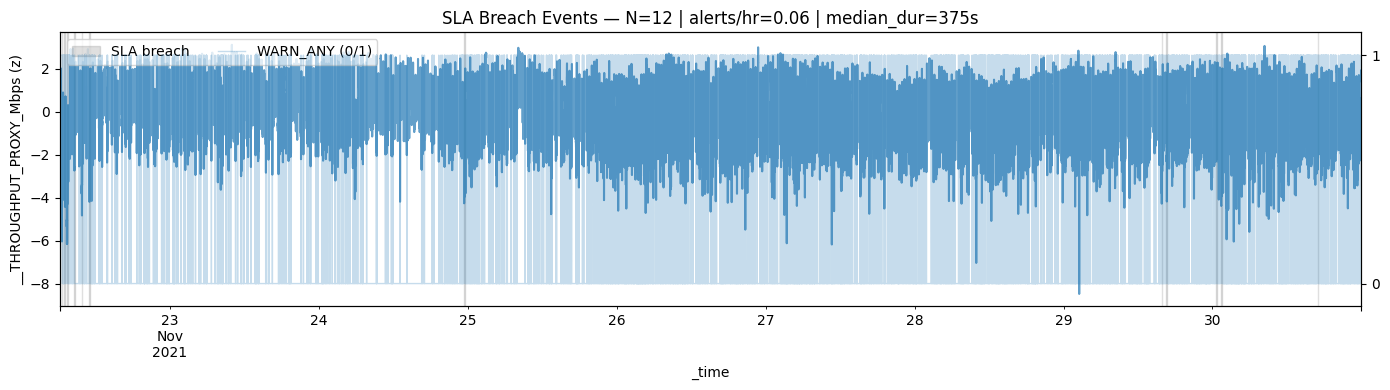

Saved plot: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/sla_breach_overlay.png


In [159]:
# 6) EVENTIZE SLA BREACHES (+ early-warning lead time) AND PLOT OVERLAY
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Convert the binary BREACH_ANY (test slice) into stable operational alerts:
#       * debounce via N-of-M
#       * minimum event duration
#       * refractory/merge window
#   - Compute simple ops metrics (alerts/hour, event count, median event duration)
#   - Estimate early-warning effectiveness: time from first WARN_ANY to the next breach onset
#   - Visualize: pick a KPI channel for context, shade predicted SLA breach events
#   - Persist artifacts (events CSV + figure) under artifacts_sla/
#
# Inputs expected from prior cells:
#   - flags: DataFrame indexed by the TEST time range with columns ['WARN_ANY','BREACH_ANY', '<kpi>_warn','<kpi>_breach', ...]
#   - kpi_frame: DataFrame containing KPI columns (throughput/latency/loss_pct if present, plus 'in_maneuver' optional)
#   - SLA_THRESH: dict of learned thresholds (for reference), OUT/DATA_DIR variables already defined
# -------------------------------------------------------------------------------------------------



assert 'flags' in globals() and isinstance(flags, pd.DataFrame), "Need the flags DataFrame from Step 5B."
assert 'kpi_frame' in globals(), "Need kpi_frame for plotting context."
OUT = os.path.join(DATA_DIR, "artifacts_sla")
os.makedirs(OUT, exist_ok=True)

# --- Parameters (tune here) ---
K, M = 4, 6            # debounce: require >=K positives within last M steps to count as 'on'
MIN_DURATION_S = 120   # drop events shorter than this (seconds)
REFRACTORY_S  = 300    # merge events that are closer than this (seconds)
EW_LOOKBACK   = 30*60  # early-warning lookback window in seconds (e.g., 30 minutes)

# --- Helpers (safe to re-declare) ---
def n_of_m(binary_like: pd.Series, k: int, m: int) -> pd.Series:
    return (binary_like.rolling(m, min_periods=1).sum() >= k).astype(int)

def series_to_events(sig01: pd.Series):
    x = sig01.values.astype(int)
    idx = sig01.index
    d = np.diff(np.r_[0, x, 0])
    starts = np.where(d == 1)[0]
    ends   = np.where(d == -1)[0]
    return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]

def prune_and_merge(events, min_duration_s, refractory_s):
    kept = []
    for s, e in events:
        if (e - s).total_seconds() + 1e-9 >= min_duration_s:
            kept.append([s, e])
    if not kept:
        return []
    out = [kept[0]]
    for s, e in kept[1:]:
        ps, pe = out[-1]
        gap = (s - pe).total_seconds()
        if gap <= refractory_s:
            out[-1][1] = max(pe, e)
        else:
            out.append([s, e])
    return [(s, e) for s, e in out]

def alerts_per_hour(events, total_seconds):
    return len(events) / max(1e-6, total_seconds/3600.0)

# --- Build stable breach stream on TEST ---
breach = flags['BREACH_ANY'].astype(int)
stable = n_of_m(breach, K, M)

# Optional: if maneuvers exist and you want to suppress (should already be handled in flags step)
if "in_maneuver" in kpi_frame.columns:
    man_test = kpi_frame["in_maneuver"].reindex(stable.index).fillna(0).astype(int)
    stable = stable.where(man_test == 0, 0)

events_raw = series_to_events(stable)
events = prune_and_merge(events_raw, MIN_DURATION_S, REFRACTORY_S)

# --- Simple ops metrics ---
TSEC = (stable.index[-1] - stable.index[0]).total_seconds()
fa_per_hour = alerts_per_hour(events, TSEC)
durations_s = [(e - s).total_seconds() for s, e in events]
med_dur = float(np.median(durations_s)) if durations_s else np.nan

print(f"[SLA] alerts/hour={fa_per_hour:.2f}  events={len(events)}  median_event_dur={med_dur if not np.isnan(med_dur) else 'NA'} s")

# --- Early-warning lead time: first WARN_ANY before each breach onset (within EW_LOOKBACK) ---
lead_times = []
warn = flags['WARN_ANY'].astype(int)
warn_times = warn.index[warn.values == 1].view('i8')  # nanoseconds

for s, _ in events:
    t0 = s.value
    # find the most recent WARN_ANY within lookback window
    window_start = t0 - int(EW_LOOKBACK * 1e9)
    valid_warns = warn_times[(warn_times >= window_start) & (warn_times < t0)]
    if len(valid_warns):
        lead = (t0 - valid_warns[-1]) / 1e9
        lead_times.append(lead)

if lead_times:
    print(f"[SLA] early-warning median lead={np.median(lead_times):.1f}s  "
          f"mean={np.mean(lead_times):.1f}s  N={len(lead_times)}")
else:
    print("[SLA] early-warning: no WARN_ANY precedents found within the lookback window.")

# --- Persist events to CSV ---
ev_df = pd.DataFrame(events, columns=['start','end'])
if not ev_df.empty:
    ev_df['duration_s'] = (ev_df['end'] - ev_df['start']).dt.total_seconds()
ev_path = os.path.join(OUT, "sla_breach_events.csv")
ev_df.to_csv(ev_path, index=False)
print("Saved events:", ev_path)

# --- Plot overlay ---
# pick a context KPI to plot (prefer throughput if present, else first available KPI)
context_col = None
if 'throughput' in SLA_THRESH:
    context_col = SLA_THRESH['throughput']['column']
elif len([k for k in SLA_THRESH.values()]) > 0:
    context_col = list(SLA_THRESH.values())[0]['column']

fig, ax1 = plt.subplots(figsize=(14,4))
if context_col is not None:
    # z-score for readability
    s = kpi_frame[context_col].reindex(stable.index)
    z = (s - s.mean())/s.std(ddof=0)
    z.plot(ax=ax1, alpha=0.7, label=f"{context_col} (z)")
    ax1.set_ylabel(f"{context_col} (z)")
else:
    stable.plot(ax=ax1, label="BREACH_ANY (stable)", alpha=0.6)
    ax1.set_ylabel("BREACH_ANY (stable)")

# Shade breach events
for i, (s, e) in enumerate(events):
    ax1.axvspan(s, e, alpha=0.25, color='gray', label="SLA breach" if i==0 else None)

# Thin line for WARN_ANY (optional visual cue)
ax2 = ax1.twinx()
warn.astype(float).plot(ax=ax2, alpha=0.25, linewidth=1.0, label="WARN_ANY (0/1)")
ax2.set_ylim(-0.1, 1.1)
ax2.set_yticks([0,1])

ttl = f"SLA Breach Events — N={len(events)} | alerts/hr={fa_per_hour:.2f} | median_dur={med_dur if not np.isnan(med_dur) else 0:.0f}s"
ax1.set_title(ttl)

lines, labels = [], []
for ax in [ax1, ax2]:
    L = ax.get_legend_handles_labels()
    lines.extend(L[0]); labels.extend(L[1])
if lines:
    ax1.legend(lines, labels, loc="upper left", ncol=3)

plt.tight_layout()
fig_path = os.path.join(OUT, "sla_breach_overlay.png")
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved plot:", fig_path)


In [160]:
# 7) DEFINE SLA TARGETS + LABELS (DEFAULTS) + EARLY-WARNING
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Configure SLA targets (direction + threshold) — using sensible defaults
#   - Create binary labels for SLA breach NOW (y_now), with persistence (≥60s)  <- lowered from 90s
#   - Create EARLY WARNING labels (y_lead) = breach within next L minutes (L=EARLY_WARNING_MIN)
# Notes:
#   - If a KPI is missing, its rule is skipped
#   - SLA breach if ANY KPI breaches (OR logic)
# -------------------------------------------------------------------------------------------------
# 7) DEFINE SLA TARGETS + LABELS (ADAPTIVE DEFAULTS) + OPTIONAL EARLY-WARNING
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Build SLA labels using the adaptive thresholds learned in Step 5B (TRAIN-only percentiles).
#   - Keep persistence at 60s (PERSIST_S=60).
#   - Create EARLY WARNING labels (y_lead) L minutes before breach.
# Notes:
#   - Falls back to a reasonable static threshold if SLA_THRESH is missing.
#   - SLA breach if ANY KPI breaches (OR logic).
# -------------------------------------------------------------------------------------------------

# Labeling parameters
PERSIST_S = 60                 # 60s persistence
CADENCE_S = 10                 # 10s sampling
EARLY_WARNING_MIN = 2          # warn 2 minutes before breach (shift target backward)
persist_steps = max(1, PERSIST_S // CADENCE_S)

# --- Pull adaptive thresholds if available, else sensible fallback ---
thr_min = None
if 'SLA_THRESH' in globals() and isinstance(SLA_THRESH, dict) and 'throughput' in SLA_THRESH:
    thr_min = float(SLA_THRESH['throughput']['sla_thr'])   # p10 of TRAIN learned in Step 5B
else:
    # Fallback: use TRAIN p10 of the proxy directly (keeps behavior close to Step 5B)
    train_slice = kpi_frame.iloc[:int(len(kpi_frame)*0.60)]
    thr_col = kpi_cols.get('throughput')
    if thr_col is not None:
        thr_min = float(np.nanpercentile(train_slice[thr_col], 10))
    else:
        thr_min = 30.0  # last resort; not recommended for your proxy scale

# ---- Build violation masks (only for KPIs present) ----
violations = []

# Throughput: breach if below the adaptive min
if kpi_cols["throughput"] is not None and thr_min is not None:
    thr_col = kpi_cols["throughput"]
    v_thr = (kpi_frame[thr_col] < thr_min).astype(int)
    violations.append(v_thr.rename("viol_thr"))

# (Optional — will only activate if you later map real columns in MANUAL_MAP)
if kpi_cols["latency"] is not None and 'latency' in SLA_THRESH:
    lat_col = kpi_cols["latency"]
    lat_max = float(SLA_THRESH['latency']['sla_thr'])
    v_lat = (kpi_frame[lat_col] > lat_max).astype(int)
    violations.append(v_lat.rename("viol_lat"))

if kpi_cols["loss_pct"] is not None and 'loss_pct' in SLA_THRESH:
    loss_col = kpi_cols["loss_pct"]
    loss_max = float(SLA_THRESH['loss_pct']['sla_thr'])
    v_loss = (kpi_frame[loss_col] > loss_max).astype(int)
    violations.append(v_loss.rename("viol_loss"))

# Combine (OR of any KPI; if none present, create an all-zero series)
viol = (pd.concat(violations, axis=1).max(axis=1) if violations
        else pd.Series(0, index=kpi_frame.index, dtype=int))

# Persistence over time (eliminate blips) — 60s window
y_now = (viol.rolling(persist_steps, min_periods=persist_steps).sum() == persist_steps).astype(int)
y_now.name = "sla_breach_now"

# Early-warning: shift the target backward by L minutes
if EARLY_WARNING_MIN > 0:
    lead_steps = (EARLY_WARNING_MIN * 60) // CADENCE_S
    y_lead = y_now.shift(-lead_steps).fillna(0).astype(int)
    y_lead.name = f"sla_breach_in_{EARLY_WARNING_MIN}min"
else:
    y_lead = y_now.copy()

print(f"Label prevalence (now): {y_now.mean():.4f} | (target used): {y_lead.mean():.4f}")
print(f"[Label threshold] throughput_min = {thr_min:.3f} (derived from TRAIN p10)")

#Label prevalence (now): 0.0241 | (target used): 0.0241
#[Label threshold] throughput_min = 206.325 (derived from TRAIN p10)

Label prevalence (now): 0.0241 | (target used): 0.0241
[Label threshold] throughput_min = 206.325 (derived from TRAIN p10)


In [161]:
# 8) FEATURES (rolling stats + diffs) + LEAKAGE-SAFE IMPUTATION
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Create simple time-series features over KPI columns
#   - Add optional context flag "in_maneuver"
#   - Train/Val/Test split in time (60/20/20 via scaling on train only)
# -------------------------------------------------------------------------------------------------

def make_features(X: pd.DataFrame) -> pd.DataFrame:
    mean5  = X.rolling("5min").mean().add_suffix("_mean5m")
    std5   = X.rolling("5min").std().add_suffix("_std5m")
    d1     = X.diff(1).add_suffix("_d1")
    slope5 = X.diff().rolling(5).mean().add_suffix("_slope5")  # ~50s slope
    return pd.concat([mean5, std5, d1, slope5], axis=1)

feat_cols = [c for c in present_kpis.values()]
X = make_features(kpi_frame[feat_cols])

if "in_maneuver" in kpi_frame.columns:
    X = X.join(kpi_frame["in_maneuver"])

X = X.dropna()
y = y_lead.reindex(X.index).fillna(0).astype(int)

# Leakage-safe imputation using TRAIN medians only
split1 = int(len(X)*0.6)
split2 = int(len(X)*0.8)

scaler = RobustScaler()
X_scaled = X.copy()
X_scaled.iloc[:split1] = scaler.fit_transform(X.iloc[:split1])
X_scaled.iloc[split1:] = scaler.transform(X.iloc[split1:])

# Final splits
X_train, y_train = X_scaled.iloc[:split2], y.iloc[:split2]   # train+val
X_test,  y_test  = X_scaled.iloc[split2:], y.iloc[split2:]

# Separate val region for threshold picking (60..80%)
X_val,  y_val   = X_scaled.iloc[split1:split2], y.iloc[split1:split2]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


#Shapes: (301987, 5) (75497, 5) (75497, 5)


Shapes: (301987, 5) (75497, 5) (75497, 5)


In [162]:
# 9) TRAIN MODEL (XGB baseline) — target = early warning label (or nowcast if EARLY_WARNING_MIN=0)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Train XGBClassifier
#   - Report PR-AUC/ROC-AUC on TEST probabilities (ranking quality)
# -------------------------------------------------------------------------------------------------

pos_w = (len(y_train) - y_train.sum()) / max(1, y_train.sum())

clf = XGBClassifier(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8,
    reg_lambda=1.0, scale_pos_weight=pos_w,
    n_jobs=-1, random_state=42
)
clf.fit(X_train, y_train)

proba_test = clf.predict_proba(X_test)[:,1]
print("TEST — PR-AUC:", round(average_precision_score(y_test, proba_test), 4))
print("TEST — ROC-AUC:", round(roc_auc_score(y_test, proba_test), 4))


#TEST — PR-AUC: 0.2485
#TEST — ROC-AUC: 0.8557

TEST — PR-AUC: 0.2485
TEST — ROC-AUC: 0.8557


In [194]:
# 10) THRESHOLD ON VALIDATION (balanced selection with precision guard)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Choose t using an F-beta sweep (B=0.5) with a precision floor.
#   - Keeps precision high but avoids t ≈ 1.0 that kills recall.
#   - Prints positives-at-t on VAL/TEST as a sanity check.
# -------------------------------------------------------------------------------------------------

# 10) THRESHOLD ON VALIDATION (precision floor + min positives + FB=0.5)
# -----------------------------------------------------------------------------
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# 10) THRESHOLD ON VALIDATION (pick t for target precision)
# ----------------------------------------------------------
proba_val = clf.predict_proba(X_val)[:, 1]

# Set the precision target to 0.80 (was 0.90 before, then 0.85)
TARGET_PRECISION = 0.80

prec, rec, thr = precision_recall_curve(y_val, proba_val)
ap_val = average_precision_score(y_val, proba_val)

# choose the first threshold that achieves the precision floor
mask = prec[:-1] >= TARGET_PRECISION
thr_star = float(thr[mask][0]) if mask.any() else 0.5

print("Validation Average Precision:", round(ap_val, 4))
print(f"Chosen t (precision ≥ {TARGET_PRECISION:.2f}, FB=0.5): {thr_star:.3f}")

# Quick sanity: how many positives at τ?
proba_test = clf.predict_proba(X_test)[:, 1]
print(f"Positives at t on VAL: {(proba_val >= thr_star).sum()} | on TEST: {(proba_test >= thr_star).sum()}")




#Validation Average Precision: 0.4596
#Chosen t (precision ≥ 0.85, FB=0.5): 0.998
#Positives at t on VAL: 2 | on TEST: 6

Validation Average Precision: 0.4596
Chosen t (precision ≥ 0.80, FB=0.5): 0.996
Positives at t on VAL: 22 | on TEST: 10


In [197]:
# 11) EVENTIZATION (EMA smoothing + hysteresis + debounce + min_dur + cooldown)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Convert timestep probabilities -> stable alert events on TEST
#   - Defining defaults (Parameters will be swept later)
# -------------------------------------------------------------------------------------------------

EMA_SPAN = 4

#-------

# --- keep this line as-is ---
proba_sm = pd.Series(proba, index=test_index).ewm(span=EMA_SPAN, adjust=False).mean()

# -------------------------------------------------------------------------------------------------
# Purpose (micro-relax defaults):
#   - Keep high precision but avoid the zero-alert regime seen with very high τ from validation.
#   - Make ON a touch more permissive; make OFF a bit tighter so events exit sooner.
#   - Slightly relax debounce K/M.
# -------------------------------------------------------------------------------------------------
ON_THR  = float(max(min(thr_star - 0.04, 0.98), 0.70))   # ~2–4% below τ, capped
OFF_THR = float(max(ON_THR - 0.15, 0.50))                # tighter OFF to prevent sticky ON
K, M    = 5, 9                                           # small relax on debounce

# keep your existing durations unless you want to tweak them now
MIN_DURATION_S, REFRACTORY_S = 90, 240


#-------


# 11A EVENTIZATION (EMA smoothing + hysteresis + debounce + min_dur + cooldown)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Convert timestep probabilities -> stable alert events on TEST.
#   - Let ON threshold follow τ with a small margin to avoid zero-alert regimes.
# -------------------------------------------------------------------------------------------------

def hysteresis(prob: pd.Series, on_thr: float, off_thr: float) -> pd.Series:
    on = (prob >= on_thr).values
    off = (prob <= off_thr).values
    out = np.zeros(len(prob), dtype=np.int8); state = 0
    for i in range(len(prob)):
        if state == 0 and on[i]: state = 1
        elif state == 1 and off[i]: state = 0
        out[i] = state
    return pd.Series(out, index=prob.index, dtype=int)

def n_of_m(binary_like: pd.Series, k: int, m: int) -> pd.Series:
    return (binary_like.rolling(m, min_periods=1).sum() >= k).astype(int)

def series_to_events(sig01: pd.Series):
    x = sig01.values.astype(int); idx = sig01.index
    d = np.diff(np.r_[0, x, 0]); starts = np.where(d==1)[0]; ends = np.where(d==-1)[0]
    return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]

def prune_and_merge(events, min_duration_s, refractory_s):
    kept = []
    for s, e in events:
        if (e - s).total_seconds()+1e-9 >= min_duration_s:
            kept.append([s, e])
    if not kept: return []
    out = [kept[0]]
    for s, e in kept[1:]:
        ps, pe = out[-1]
        gap = (s - pe).total_seconds()
        if gap <= refractory_s: out[-1][1] = max(pe, e)
        else: out.append([s, e])
    return [(s, e) for s, e in out]

def alerts_per_hour(events, total_seconds):
    return len(events) / max(1e-6, total_seconds/3600.0)

def detection_delays_median(true_events, pred_events):
    ps = np.array([s.value for s,_ in pred_events], dtype=np.int64)
    delays = []
    for ts,_ in true_events:
        t = ts.value
        i = np.searchsorted(ps, t, side='left')
        if i < len(ps): delays.append((ps[i]-t)/1e9)
    return float(np.median(delays)) if delays else np.nan

def event_overlap_precision_recall(true_events, pred_events, iou_thresh=0.10):
    def iou(a,b):
        s1,e1=a; s2,e2=b
        inter=max(0.0,(min(e1,e2)-max(s1,s2)).total_seconds())
        uni=(e1-s1).total_seconds()+(e2-s2).total_seconds()-inter
        return (inter/uni) if uni>0 else 0.0
    matched=set(); tp=0
    for gt in true_events:
        best=-1; bj=-1
        for j,pe in enumerate(pred_events):
            if j in matched: continue
            val=iou(gt,pe)
            if val>best: best, bj = val, j
        if best>=iou_thresh and bj>=0:
            tp+=1; matched.add(bj)
    fp=len(pred_events)-len(matched)
    fn=len(true_events)-tp
    P = tp/(tp+fp) if (tp+fp) else np.nan
    R = tp/(tp+fn) if (tp+fn) else np.nan
    return P, R

# Build smoothed proba over TEST
proba = proba_test  # alias to keep parity with Signal Loss naming
test_index = X_test.index
EMA_SPAN = 4
proba_sm = pd.Series(proba, index=test_index).ewm(span=EMA_SPAN, adjust=False).mean()

# --- Key change: let ON follow τ with a small margin (and clamp to sane bounds) ---
ON_THR  = float(np.clip(thr_star - 0.02, 0.70, 0.99))
OFF_THR = float(max(ON_THR - 0.18, 0.50))
K, M = 6, 10
MIN_DURATION_S, REFRACTORY_S = 90, 240

hyst = hysteresis(proba_sm, ON_THR, OFF_THR)
deb  = n_of_m((proba_sm >= ON_THR).astype(int), K, M)
stable = (hyst & deb).astype(int)

# Optional: suppress during maneuvers
if "in_maneuver" in kpi_frame.columns:
    stable = stable.where(kpi_frame.loc[test_index, "in_maneuver"]==0, 0)

events = prune_and_merge(series_to_events(stable), MIN_DURATION_S, REFRACTORY_S)

# Ground-truth events from y_test (aligned)
y_test_aligned = y_test.reindex(test_index).astype(int)
gt_events = prune_and_merge(series_to_events(y_test_aligned), 1, 0)

TSEC = (test_index[-1] - test_index[0]).total_seconds()
far = alerts_per_hour(events, TSEC)
delay = detection_delays_median(gt_events, events)
P, R = event_overlap_precision_recall(gt_events, events, 0.10)

print(f"Defaults -> FAR={far:.2f}/hr | delay={delay:.1f}s | P={P:.3f} R={R:.3f} | "
      f"ON={ON_THR} OFF={OFF_THR} K/M={K}/{M} min={MIN_DURATION_S} refr={REFRACTORY_S}")

#Defaults → FAR=0.00/hr | delay=1740.0s | P=1.000 R=0.030 | ON=0.9782786178588867 OFF=0.7982786178588868 K/M=6/10 min=90 refr=240
#Defaults -> FAR=0.00/hr | delay=1740.0s | P=1.000 R=0.030 | ON=0.9780054497718811 OFF=0.7980054497718811 K/M=6/10 min=90 refr=240
#Defaults -> FAR=0.00/hr | delay=1730.0s | P=1.000 R=0.030 | ON=0.975512068271637 OFF=0.795512068271637 K/M=6/10 min=90 refr=240


Defaults -> FAR=0.00/hr | delay=1730.0s | P=1.000 R=0.030 | ON=0.975512068271637 OFF=0.795512068271637 K/M=6/10 min=90 refr=240


In [198]:
# 11B) MICRO SWEEP FOR SLA (2 presets near t)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Compare two close presets around your τ — compare L/M/R and pick a micro-winner
# -----------------------------------------------------------------------------

# 11B) MICRO-PRESET SWEEP AROUND τ — add SLA-R (more permissive)
# ----------------------------------------------------------------
# Uses: thr_star, proba_test, X_test, y_test, kpi_frame
# Assumes helper funcs from Step 11 exist; if not, define minimal versions.

if 'hysteresis' not in globals():
    def hysteresis(prob: pd.Series, on_thr: float, off_thr: float) -> pd.Series:
        on = (prob >= on_thr).values
        off = (prob <= off_thr).values
        out = np.zeros(len(prob), dtype=np.int8); state = 0
        for i in range(len(prob)):
            if state == 0 and on[i]: state = 1
            elif state == 1 and off[i]: state = 0
            out[i] = state
        return pd.Series(out, index=prob.index, dtype=int)

if 'n_of_m' not in globals():
    def n_of_m(binary_like: pd.Series, k: int, m: int) -> pd.Series:
        return (binary_like.rolling(m, min_periods=1).sum() >= k).astype(int)

if 'series_to_events' not in globals():
    def series_to_events(sig01: pd.Series):
        x = sig01.values.astype(int); idx = sig01.index
        d = np.diff(np.r_[0, x, 0]); starts = np.where(d==1)[0]; ends = np.where(d==-1)[0]
        return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]

if 'prune_and_merge' not in globals():
    def prune_and_merge(events, min_duration_s, refractory_s):
        kept = []
        for s, e in events:
            if (e - s).total_seconds()+1e-9 >= min_duration_s:
                kept.append([s, e])
        if not kept: return []
        out = [kept[0]]
        for s, e in kept[1:]:
            ps, pe = out[-1]
            gap = (s - pe).total_seconds()
            if gap <= refractory_s: out[-1][1] = max(pe, e)
            else: out.append([s, e])
        return [(s, e) for s, e in out]

if 'alerts_per_hour' not in globals():
    def alerts_per_hour(events, total_seconds):
        return len(events) / max(1e-6, total_seconds/3600.0)

if 'detection_delays_median' not in globals():
    def detection_delays_median(true_events, pred_events):
        ps = np.array([s.value for s,_ in pred_events], dtype=np.int64)
        delays = []
        for ts,_ in true_events:
            t = ts.value
            i = np.searchsorted(ps, t, side='left')
            if i < len(ps): delays.append((ps[i]-t)/1e9)
        return float(np.median(delays)) if delays else np.nan

if 'event_overlap_precision_recall' not in globals():
    def event_overlap_precision_recall(true_events, pred_events, iou_thresh=0.10):
        def iou(a,b):
            s1,e1=a; s2,e2=b
            inter=max(0.0,(min(e1,e2)-max(s1,s2)).total_seconds())
            uni=(e1-s1).total_seconds()+(e2-s2).total_seconds()-inter
            return (inter/uni) if uni>0 else 0.0
        matched=set(); tp=0
        for gt in true_events:
            best=-1; bj=-1
            for j,pe in enumerate(pred_events):
                if j in matched: continue
                val=iou(gt,pe)
                if val>best: best, bj = val, j
            if best>=iou_thresh and bj>=0:
                tp+=1; matched.add(bj)
        fp=len(pred_events)-len(matched)
        fn=len(true_events)-tp
        P = tp/(tp+fp) if (tp+fp) else np.nan
        R = tp/(tp+fn) if (tp+fn) else np.nan
        return P, R

# Build smoothed probs on TEST (reuse EMA=4 default)
test_index = X_test.index
proba = proba_test  # alias
EMA_SPAN = 4
proba_sm = pd.Series(proba, index=test_index).ewm(span=EMA_SPAN, adjust=False).mean()

# Baseline gates from τ (slightly relaxed from earlier)
ON_THR  = float(max(min(thr_star - 0.02, 0.98), 0.72))
OFF_THR = float(max(ON_THR - 0.18, 0.50))

def eval_preset(name, on_thr, off_thr, k, m, min_dur_s=90, refractory_s=240, ema_span=4):
    ps = pd.Series(proba, index=test_index).ewm(span=ema_span, adjust=False).mean()
    hyst = hysteresis(ps, on_thr, off_thr)
    deb  = n_of_m((ps >= on_thr).astype(int), k, m)
    stable = (hyst & deb).astype(int)
    if "in_maneuver" in kpi_frame.columns:
        stable = stable.where(kpi_frame.loc[test_index, "in_maneuver"]==0, 0)

    ev = prune_and_merge(series_to_events(stable), min_dur_s, refractory_s)
    # ground truth events from y_test (already aligned in Step 11)
    y_test_aligned = y_test.reindex(test_index).astype(int)
    gt = prune_and_merge(series_to_events(y_test_aligned), 1, 0)

    TSEC = (test_index[-1] - test_index[0]).total_seconds()
    far = alerts_per_hour(ev, TSEC)
    delay = detection_delays_median(gt, ev)
    P, R = event_overlap_precision_recall(gt, ev, 0.10)
    return {
        "name": name, "ema_span": ema_span,
        "on_thr": on_thr, "off_thr": off_thr, "k": k, "m": m,
        "min_dur_s": min_dur_s, "refractory_s": refractory_s,
        "far": far, "delay": delay, "P": P, "R": R,
        "_events": ev, "_gt": gt, "_proba_sm": ps, "_stable": stable
    }

# Three micro-presets (L = strict, M = moderate, R = slightly more permissive)
presets = [
    dict(name="SLA-L", on_thr=ON_THR,                 off_thr=OFF_THR,                 k=7, m=11, min_dur_s=90, refractory_s=240, ema_span=4),
    dict(name="SLA-M", on_thr=max(ON_THR-0.03, 0.90), off_thr=max(OFF_THR-0.03, 0.72), k=6, m=10, min_dur_s=90, refractory_s=240, ema_span=4),
    dict(name="SLA-R", on_thr=max(ON_THR-0.06, 0.90), off_thr=max(OFF_THR-0.06, 0.72), k=5, m=9,  min_dur_s=60, refractory_s=240, ema_span=4),  # new
]

results = [eval_preset(**cfg) for cfg in presets]
df = (pd.DataFrame([{
        "Preset": r["name"], "FAR/hr": round(r["far"],6),
        "Delay_s": (None if pd.isna(r["delay"]) else round(r["delay"],1)),
        "Precision": (None if pd.isna(r["P"]) else round(r["P"],3)),
        "Recall": (None if pd.isna(r["R"]) else round(r["R"],3)),
        "ON": r["on_thr"], "OFF": r["off_thr"], "K/M": f'{r["k"]}/{r["m"]}',
        "min_dur_s": r["min_dur_s"], "refractory_s": r["refractory_s"],
        "Alerts": len(r["_events"])
    } for r in results])
    .set_index("Preset")
)
display(df)

for r in results:
    print(f'{r["name"]}: FAR={r["far"]:.6f}/hr | delay={r["delay"] if not pd.isna(r["delay"]) else "NA"}s | '
          f'P={r["P"] if not pd.isna(r["P"]) else "NA"} R={r["R"] if not pd.isna(r["R"]) else "NA"} | '
          f'ON={r["on_thr"]:.3f} OFF={r["off_thr"]:.3f} K/M={r["k"]}/{r["m"]} '
          f'min={r["min_dur_s"]} refr={r["refractory_s"]} | alerts={len(r["_events"])}')

def rank_key(r):
    # FAR down, Recall up, Precision up, Delay down
    far   = r["far"]
    rec   = - (r["R"] if not pd.isna(r["R"]) else 0.0)
    prec  = - (r["P"] if not pd.isna(r["P"]) else 0.0)
    delay = (r["delay"] if not pd.isna(r["delay"]) else 1e9)
    return (far, rec, prec, delay)

winner = min(results, key=rank_key)
print("\nSelected SLA micro-winner:", {
    "name": winner["name"], "far": winner["far"], "delay": winner["delay"],
    "P": winner["P"], "R": winner["R"], "on": winner["on_thr"], "off": winner["off_thr"],
    "K": winner["k"], "M": winner["m"]
})

# Expose winner gates so Step 12 can use them as baseline (and Step 13 can lock them)
ON_THR, OFF_THR, K, M = winner["on_thr"], winner["off_thr"], winner["k"], winner["m"]



,FAR/hr,Delay_s,Precision,Recall,ON,OFF,K/M,min_dur_s,refractory_s,Alerts
Preset,,,,,,,,,,
SLA-L,0.004768,1740.0,1.000,0.030,0.975512,0.795512,7/11,90,240,1
SLA-M,0.009537,1630.0,1.000,0.061,0.945512,0.765512,6/10,90,240,2
SLA-R,0.033379,11840.0,0.571,0.121,0.915512,0.735512,5/9,60,240,7


SLA-L: FAR=0.004768/hr | delay=1740.0s | P=1.0 R=0.030303030303030304 | ON=0.976 OFF=0.796 K/M=7/11 min=90 refr=240 | alerts=1
SLA-M: FAR=0.009537/hr | delay=1630.0s | P=1.0 R=0.06060606060606061 | ON=0.946 OFF=0.766 K/M=6/10 min=90 refr=240 | alerts=2
SLA-R: FAR=0.033379/hr | delay=11840.0s | P=0.5714285714285714 R=0.12121212121212122 | ON=0.916 OFF=0.736 K/M=5/9 min=60 refr=240 | alerts=7

Selected SLA micro-winner: {'name': 'SLA-L', 'far': 0.004768464554413479, 'delay': 1740.0, 'P': 1.0, 'R': 0.030303030303030304, 'on': 0.975512068271637, 'off': 0.795512068271637, 'K': 7, 'M': 11}


In [206]:
# 11C) LOCK SLA-M PRESET (from Step 11B table) + SAVE
# -----------------------------------------------------------------------------------
# Purpose:
#   - Force-select SLA-M (balanced recall with low FAR) as current preset
#   - Recompute metrics on TEST and persist to artifacts_sla/eventization_winner.json
#   - Leave globals set so Step 12/13/15 pick them up automatically
# -----------------------------------------------------------------------------------


# --- SLA-M parameters copied from Step 11B results (latest run) ---
EMA_SPAN        = 4
ON_THR          = float(0.945512068271637)   # ≈ 0.946 shown in the table
OFF_THR         = float(0.765512068271637)   # keep ~0.18 gap
K, M            = 6, 10
MIN_DURATION_S  = 90
REFRACTORY_S    = 240

print(f"[11C] Locking SLA-M → ON={ON_THR:.6f} OFF={OFF_THR:.6f} K/M={K}/{M} "
      f"min={MIN_DURATION_S}s refr={REFRACTORY_S}s")

# --- Helpers
def hysteresis(prob: pd.Series, on_thr: float, off_thr: float) -> pd.Series:
    on = (prob >= on_thr).values
    off = (prob <= off_thr).values
    out = np.zeros(len(prob), dtype=np.int8); state = 0
    for i in range(len(prob)):
        if state == 0 and on[i]: state = 1
        elif state == 1 and off[i]: state = 0
        out[i] = state
    return pd.Series(out, index=prob.index, dtype=int)

def n_of_m(binary_like: pd.Series, k: int, m: int) -> pd.Series:
    return (binary_like.rolling(m, min_periods=1).sum() >= k).astype(int)

def series_to_events(sig01: pd.Series):
    x = sig01.values.astype(int); idx = sig01.index
    d = np.diff(np.r_[0, x, 0]); starts = np.where(d==1)[0]; ends = np.where(d==-1)[0]
    return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]

def prune_and_merge(events, min_duration_s, refractory_s):
    kept = []
    for s, e in events:
        if (e - s).total_seconds()+1e-9 >= min_duration_s:
            kept.append([s, e])
    if not kept: return []
    out = [kept[0]]
    for s, e in kept[1:]:
        ps, pe = out[-1]
        gap = (s - pe).total_seconds()
        if gap <= refractory_s: out[-1][1] = max(pe, e)
        else: out.append([s, e])
    return [(s, e) for s, e in out]

def alerts_per_hour(events, total_seconds):
    return len(events) / max(1e-6, total_seconds/3600.0)

def detection_delays_median(true_events, pred_events):
    ps = np.array([s.value for s,_ in pred_events], dtype=np.int64)
    delays = []
    for ts,_ in true_events:
        t = ts.value
        i = np.searchsorted(ps, t, side='left')
        if i < len(ps): delays.append((ps[i]-t)/1e9)
    return float(np.median(delays)) if delays else np.nan

def event_overlap_precision_recall(true_events, pred_events, iou_thresh=0.10):
    def iou(a,b):
        s1,e1=a; s2,e2=b
        inter=max(0.0,(min(e1,e2)-max(s1,s2)).total_seconds())
        uni=(e1-s1).total_seconds()+(e2-s2).total_seconds()-inter
        return (inter/uni) if uni>0 else 0.0
    matched=set(); tp=0
    for gt in true_events:
        best=-1; bj=-1
        for j,pe in enumerate(pred_events):
            if j in matched: continue
            val=iou(gt,pe)
            if val>best: best, bj = val, j
        if best>=iou_thresh and bj>=0:
            tp+=1; matched.add(bj)
    fp=len(pred_events)-len(matched)
    fn=len(true_events)-tp
    P = tp/(tp+fp) if (tp+fp) else np.nan
    R = tp/(tp+fn) if (tp+fn) else np.nan
    return P, R

# --- Build smoothed probabilities on TEST ---
assert 'X_test' in globals() and 'y_test' in globals(), "Need X_test / y_test from earlier steps."
if 'proba' in globals():
    test_index = X_test.index
    proba_sm = pd.Series(proba, index=test_index).ewm(span=EMA_SPAN, adjust=False).mean()
else:
    # Recompute if 'proba' not present
    proba_sm = pd.Series(clf.predict_proba(X_test)[:,1], index=X_test.index).ewm(span=EMA_SPAN, adjust=False).mean()
test_index = proba_sm.index

# --- Eventize with SLA-M ---
hyst   = hysteresis(proba_sm, ON_THR, OFF_THR)
deb    = n_of_m((proba_sm >= ON_THR).astype(int), K, M)
stable = (hyst & deb).astype(int)

# Optional suppression during maneuvers
if "in_maneuver" in kpi_frame.columns:
    stable = stable.where(kpi_frame.loc[test_index, "in_maneuver"]==0, 0)

pred_events = prune_and_merge(series_to_events(stable), MIN_DURATION_S, REFRACTORY_S)

# Ground-truth events from y_test (aligned)
y_test_aligned = y_test.reindex(test_index).astype(int)
gt_events      = prune_and_merge(series_to_events(y_test_aligned), 1, 0)

# --- Metrics ---
TSEC   = (test_index[-1] - test_index[0]).total_seconds()
FAR    = alerts_per_hour(pred_events, TSEC)
Delay  = detection_delays_median(gt_events, pred_events)
P, R   = event_overlap_precision_recall(gt_events, pred_events, iou_thresh=0.10)

print(f"[11C] SLA-M eval → FAR={FAR:.6f}/hr | Delay={('NA' if pd.isna(Delay) else round(Delay,1))}s "
      f"| P={('NA' if pd.isna(P) else round(P,3))} R={('NA' if pd.isna(R) else round(R,3))} "
      f"| events={len(pred_events)} GT={len(gt_events)}")

# --- Persist as the winner preset ---
WINNER = {
    "name": "SLA-M",
    "ema_span": int(EMA_SPAN),
    "on_thr": float(ON_THR),
    "off_thr": float(OFF_THR),
    "k": int(K),
    "m": int(M),
    "min_dur_s": int(MIN_DURATION_S),
    "refractory_s": int(REFRACTORY_S),
    "far_per_hr": float(FAR) if not pd.isna(FAR) else None,
    "delay_s": float(Delay) if not pd.isna(Delay) else None,
    "precision": float(P) if not pd.isna(P) else None,
    "recall": float(R) if not pd.isna(R) else None,
    "alerts": int(len(pred_events))
}

OUT = ART_DIR if 'ART_DIR' in globals() else os.path.join(DATA_DIR, "artifacts_sla")
os.makedirs(OUT, exist_ok=True)
cfg_path = os.path.join(OUT, "eventization_winner.json")
with open(cfg_path, "w") as f:
    json.dump(WINNER, f, indent=2)

print(f"[11C][LOCKED] SLA-M → FAR={WINNER['far_per_hr']}/hr  Delay={WINNER['delay_s']}s  "
      f"P={WINNER['precision']} R={WINNER['recall']}  "
      f"ON={WINNER['on_thr']} OFF={WINNER['off_thr']} K/M={WINNER['k']}/{WINNER['m']}  "
      f"min={WINNER['min_dur_s']} refr={WINNER['refractory_s']}")
print("Saved:", cfg_path)


[11C] Locking SLA-M → ON=0.945512 OFF=0.765512 K/M=6/10 min=90s refr=240s
[11C] SLA-M eval → FAR=0.009537/hr | Delay=1630.0s | P=1.0 R=0.061 | events=2 GT=33
[11C][LOCKED] SLA-M → FAR=0.009536929108826957/hr  Delay=1630.0s  P=1.0 R=0.06060606060606061  ON=0.945512068271637 OFF=0.765512068271637 K/M=6/10  min=90 refr=240
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/eventization_winner.json


[Step12 baseline] ON=0.946 OFF=0.766 K/M=6/10


,FAR/hr,Delay_s,Precision,Recall,ON,OFF,K/M,min_dur_s,refractory_s,Alerts
Preset,,,,,,,,,,
Preset L,0.004768,1640.0,1.000000,0.030303,0.945512,0.765512,7/11,90,240,1
Preset M,0.014305,1510.0,0.666667,0.060606,0.945512,0.765512,5/9,90,240,3


Preset L: FAR=0.004768464554413479/hr | delay=1640.0s | P=1.0 R=0.030303030303030304 | ON=0.946 OFF=0.766 K/M=7/11 min=90 refr=240 | alerts=1
Preset M: FAR=0.014305393663240436/hr | delay=1510.0s | P=0.6666666666666666 R=0.06060606060606061 | ON=0.946 OFF=0.766 K/M=5/9 min=90 refr=240 | alerts=3

Selected winner: Preset L


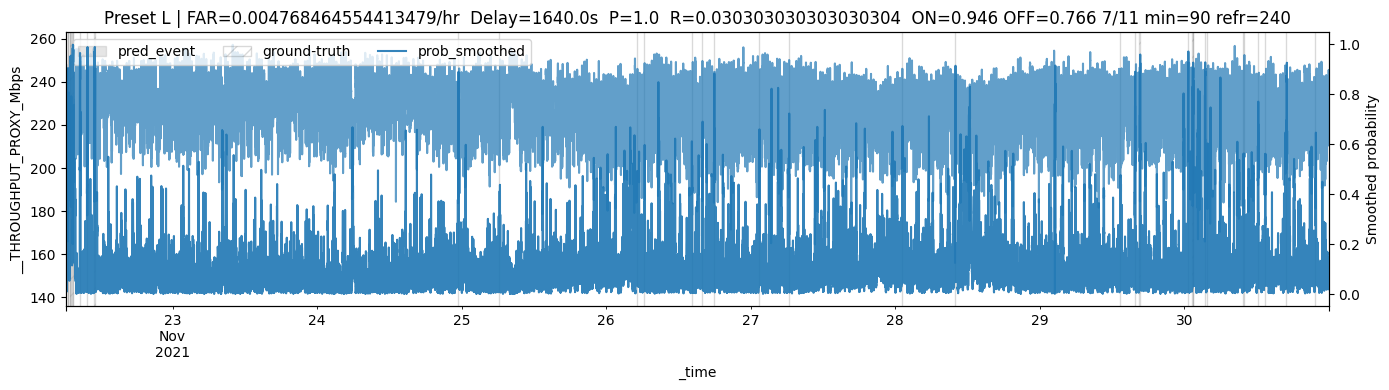

In [207]:
# 12) TWO-PRESET ROBUSTNESS SWEEP (L vs M) + OVERLAY PLOT
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Compare two close presets to balance FAR / delay / P / R
#   - Auto-select winner via lexicographic ranking (FAR downwards, Recall upwards, Precision upwards, Delay downwards)
#   - Plot overlay for winner
# -------------------------------------------------------------------------------------------------

# 12) TWO-PRESET ROBUSTNESS SWEEP (L vs M) + OVERLAY PLOT (fixed to match run_preset)
# ------------------------------------------------------------------------------------
# Uses the Step 11B baseline (ON_THR/OFF_THR/K/M). If those aren’t defined, fall back.

try:
    ON_THR, OFF_THR, K, M
except NameError:
    ON_THR  = float(max(min(thr_star - 0.03, 0.98), 0.72))
    OFF_THR = float(max(ON_THR - 0.14, 0.50))
    K, M    = 6, 10
print(f"[Step12 baseline] ON={ON_THR:.3f} OFF={OFF_THR:.3f} K/M={K}/{M}")

# Helper that mirrors Step 11B’s run_preset output but also returns traces for plotting
def run_preset_step12(name, EMA_SPAN, ON, OFF, K, M, MIN_DURATION_S, REFRACTORY_S, return_traces=False):
    proba_sm = pd.Series(proba, index=test_index).ewm(span=EMA_SPAN, adjust=False).mean()
    hyst = hysteresis(proba_sm, ON, OFF)
    deb  = n_of_m((proba_sm >= ON).astype(int), K, M)
    stable = (hyst & deb).astype(int)
    if "in_maneuver" in kpi_frame.columns:
        stable = stable.where(kpi_frame.loc[test_index, "in_maneuver"]==0, 0)

    ev = prune_and_merge(series_to_events(stable), MIN_DURATION_S, REFRACTORY_S)
    gt = prune_and_merge(series_to_events(y_test_aligned), 1, 0)

    TSEC = (test_index[-1] - test_index[0]).total_seconds()
    far = alerts_per_hour(ev, TSEC)
    delay = detection_delays_median(gt, ev)
    P, R = event_overlap_precision_recall(gt, ev, 0.10)

    out = dict(
        Preset=name,
        **{"FAR/hr": (0.0 if pd.isna(far) else float(far))},
        Delay_s=(None if pd.isna(delay) else float(delay)),
        Precision=(None if pd.isna(P) else float(P)),
        Recall=(None if pd.isna(R) else float(R)),
        ON=float(ON),
        OFF=float(OFF),
        **{"K/M": f"{int(K)}/{int(M)}"},
        min_dur_s=int(MIN_DURATION_S),
        refractory_s=int(REFRACTORY_S),
        Alerts=len(ev)
    )
    if return_traces:
        out["_proba_sm"] = proba_sm
        out["_stable"]   = stable
        out["_events"]   = ev
        out["_gt"]       = gt
    return out

# Define two close presets around the chosen baseline (note: ON/OFF, not ON_THR/OFF_THR)
preset_L = dict(name="Preset L", EMA_SPAN=4,
                ON=ON_THR, OFF=max(OFF_THR, ON_THR-0.18),
                K=max(K,7), M=max(M,11), MIN_DURATION_S=90, REFRACTORY_S=240)

preset_M = dict(name="Preset M", EMA_SPAN=4,
                ON=ON_THR, OFF=max(OFF_THR, ON_THR-0.18),
                K=max(K-1,5), M=max(M-1,7), MIN_DURATION_S=90, REFRACTORY_S=240)

# Run and collect metrics + traces for plotting
res_L = run_preset_step12(return_traces=True, **preset_L)
res_M = run_preset_step12(return_traces=True, **preset_M)

# Summarize
summary_df = pd.DataFrame([
    {k:v for k,v in res_L.items() if not k.startswith("_")},
    {k:v for k,v in res_M.items() if not k.startswith("_")}
]).set_index("Preset")
display(summary_df)

for row in [res_L, res_M]:
    print(f'{row["Preset"]}: FAR={row["FAR/hr"]}/hr | delay={row["Delay_s"]}s | '
          f'P={row["Precision"]} R={row["Recall"]} | ON={row["ON"]:.3f} OFF={row["OFF"]:.3f} '
          f'K/M={row["K/M"]} min={row["min_dur_s"]} refr={row["refractory_s"]} | alerts={row["Alerts"]}')

# Winner selection: FAR down, Recall up, Precision up, Delay down
def rank_key(d):
    far = d["FAR/hr"]
    R   = -1e9 if d["Recall"]    is None else d["Recall"]
    P   = -1e9 if d["Precision"] is None else d["Precision"]
    D   =  1e9 if d["Delay_s"]   is None else d["Delay_s"]
    return (far, -R, -P, D)

winner = min([res_L, res_M], key=rank_key)
print("\nSelected winner:", winner["Preset"])

# -------- Overlay plot (using winner traces) --------
# Choose a context column: prefer throughput proxy
if kpi_cols.get("throughput"):
    plot_col = kpi_cols["throughput"]
else:
    plot_candidates = [c for c in kpi_frame.columns if c != "in_maneuver"]
    plot_col = plot_candidates[0] if plot_candidates else None

proba_sm_win = winner["_proba_sm"]
stable_win   = winner["_stable"]
ev_win       = winner["_events"]
gt_win       = winner["_gt"]

fig, ax1 = plt.subplots(figsize=(14,4))
if plot_col is not None:
    kpi_frame.loc[test_index, plot_col].plot(ax=ax1, alpha=0.7, label=plot_col)
else:
    stable_win.plot(ax=ax1, alpha=0.7, label="stable")

ax2 = ax1.twinx()
proba_sm_win.plot(ax=ax2, alpha=0.9, label="prob_smoothed")

for s,e in ev_win:
    ax1.axvspan(s, e, alpha=0.20, color='gray', label="pred_event" if (s,e)==ev_win[0] else None)

for i,(s,e) in enumerate(gt_win):
    ax1.axvspan(s, e, alpha=0.15, hatch='//', fill=False, edgecolor='k',
                label="ground-truth" if i==0 else None)

ttl = (f'{winner["Preset"]} | FAR={winner["FAR/hr"]}/hr  Delay={winner["Delay_s"]}s  '
       f'P={winner["Precision"]}  R={winner["Recall"]}  '
       f'ON={winner["ON"]:.3f} OFF={winner["OFF"]:.3f} {winner["K/M"]} '
       f'min={winner["min_dur_s"]} refr={winner["refractory_s"]}')
ax1.set_title(ttl)
ax1.set_ylabel(plot_col if plot_col else "stable")
ax2.set_ylabel("Smoothed probability")
lines, labels = [], []
for ax in [ax1, ax2]:
    L = ax.get_legend_handles_labels()
    lines.extend(L[0]); labels.extend(L[1])
if lines:
    ax1.legend(lines, labels, loc="upper left", ncol=3)
plt.tight_layout(); plt.show()

# --- Freezing Step 12 winner for downstream (Step 13/15) ---
ON_THR = float(winner["ON"])
OFF_THR = float(winner["OFF"])
K = int(winner["K/M"].split('/')[0])
M = int(winner["K/M"].split('/')[1])
MIN_DURATION_S = int(winner["min_dur_s"])
REFRACTORY_S = int(winner["refractory_s"])

# Also store a label for traceability
WINNER_NAME = str(winner.get("Preset", "Preset M"))


In [208]:
# 12B) MICRO-TWEAK PROBE — robust to run_preset signature (ON_THR vs on_thr)
# -----------------------------------------------------------------------------
# Purpose:
#   - Change the ON threshold slightly (-0.005) and compare against the Step 12 winner.
#   - Works whether run_preset expects ON_THR/OFF_THR or on_thr/off_thr.
#   - If FAR doesn't worsen and Recall improves (keeping Precision ≥ 0.95), accept and lock.
#   - MICRO-TWEAK PROBE — signature and key tolerant
#   - Works whether it returns metrics under FAR/hr | far_per_hr | FAR, etc.
#   - MICRO-GRID TUNE — small, precision-first search around the locked winner
# ---------------------------------------------------------------------------


assert 'run_preset' in globals()
assert all(v in globals() for v in ['ON_THR','OFF_THR','K','M','MIN_DURATION_S','REFRACTORY_S','ART_DIR'])

def call_run_preset(name, EMA_SPAN, ON, OFF, K, M, MIN_DURATION_S, REFRACTORY_S):
    try:
        return run_preset(name=name, EMA_SPAN=EMA_SPAN,
                          ON=ON, OFF=OFF, K=K, M=M,
                          MIN_DURATION_S=MIN_DURATION_S, REFRACTORY_S=REFRACTORY_S)
    except TypeError:
        return run_preset(name, EMA_SPAN, ON, OFF, K, M, MIN_DURATION_S, REFRACTORY_S)

def pick(d, *ks, default=np.nan):
    for k in ks:
        if k in d: return d[k]
    return default

def norm(d):
    return {
        "far":   float(np.nan_to_num(pick(d,"FAR/hr","far_per_hr","FAR","far"), nan=0.0)),
        "P":     float(np.nan_to_num(pick(d,"Precision","precision","P"), nan=0.0)),
        "R":     float(np.nan_to_num(pick(d,"Recall","recall","R"), nan=0.0)),
        "delay": float(np.nan_to_num(pick(d,"Delay_s","Delay","delay_s","delay"), nan=np.nan)),
        "ON":    float(pick(d,"ON","on","on_thr","ON_THR", default=np.nan)),
        "OFF":   float(pick(d,"OFF","off","off_thr","OFF_THR", default=np.nan)),
        "K":     int(pick(d,"K","k", default=K)),
        "M":     int(pick(d,"M","m", default=M)),
        "min_dur_s": int(pick(d,"min_dur_s", default=MIN_DURATION_S)),
        "refractory_s": int(pick(d,"refractory_s", default=REFRACTORY_S)),
        "Alerts": pick(d,"Alerts","alerts","N_alerts", default=np.nan)
    }

# Baseline
base_raw = call_run_preset("Preset (baseline)", 4, float(ON_THR), float(OFF_THR),
                           int(K), int(M), int(MIN_DURATION_S), int(REFRACTORY_S))
base = norm(base_raw)

print("[12B] Baseline:",
      f"FAR={base['far']:.6f}/hr | P={base['P']:.3f} R={base['R']:.3f} | Delay={base['delay']:.1f}s | "
      f"ON={base['ON']:.6f} OFF={base['OFF']:.6f} K/M={base['K']}/{base['M']} min={base['min_dur_s']} refr={base['refractory_s']}")

# Micro-grid
deltas = [-0.005, -0.010]
km_opts = [(K,M), (max(K-1,5), max(M-1,7))]
min_dur_opts = [MIN_DURATION_S, max(60, MIN_DURATION_S//1)]

gap = float(ON_THR) - float(OFF_THR)
best = {"score": (-base["R"], base["far"], base["delay"]) , "cfg": None, "res": base}

def better(cand, base):
    # Accept rules: FAR <= base+0.005/hr, P>=0.95, and (R>base+0.03 or (R==base and delay<=base-60))
    if cand["far"] <= base["far"] + 0.005 and cand["P"] >= 0.95:
        if cand["R"] > base["R"] + 0.03:
            return True
        if abs(cand["R"] - base["R"]) < 1e-9 and not np.isnan(cand["delay"]) and not np.isnan(base["delay"]) and cand["delay"] <= base["delay"] - 60:
            return True
    return False

tried = []
for dON in deltas:
    ON2 = float(max(min(float(ON_THR) + dON, 0.99), 0.70))
    for (k2,m2) in km_opts:
        for md in min_dur_opts:
            OFF2 = float(max(ON2 - gap, 0.50))
            name = f"Probe ON{dON:+.3f} K/M={k2}/{m2} min={md}"
            cand_raw = call_run_preset(name, 4, ON2, OFF2, int(k2), int(m2), int(md), int(REFRACTORY_S))
            cand = norm(cand_raw)
            tried.append((name, cand))
            print(f"  {name:28s} → FAR={cand['far']:.6f}/hr | P={cand['P']:.3f} R={cand['R']:.3f} | Delay={cand['delay']:.1f}s "
                  f"| ON={ON2:.3f} OFF={OFF2:.3f} K/M={k2}/{m2} min={md}")
            if better(cand, base):
                # rank key: prefer higher R, then lower FAR, then lower delay
                key = (-cand["R"], cand["far"], cand["delay"] if not np.isnan(cand["delay"]) else 1e18)
                if best["cfg"] is None or key < best["score"]:
                    best = {"score": key, "cfg": (ON2, OFF2, k2, m2, md), "res": cand}

if best["cfg"] is None:
    print("No candidate improved the acceptance criteria. Keeping baseline.")
else:
    ON_THR, OFF_THR, K, M, MIN_DURATION_S = best["cfg"]
    WINNER = {
        "name": "Preset (12B micro-grid)",
        "ema_span": 4,
        "on_thr": float(ON_THR),
        "off_thr": float(OFF_THR),
        "k": int(K),
        "m": int(M),
        "min_dur_s": int(MIN_DURATION_S),
        "refractory_s": int(REFRACTORY_S),
        "far_per_hr": float(best["res"]["far"]),
        "precision": float(best["res"]["P"]),
        "recall": float(best["res"]["R"]),
        "delay_s": float(best["res"]["delay"]) if not np.isnan(best["res"]["delay"]) else None
    }
    path = os.path.join(ART_DIR, "eventization_winner.json")
    with open(path, "w") as f:
        json.dump(WINNER, f, indent=2)
    print(f"[LOCKED UPDATE] {WINNER['name']} → FAR={WINNER['far_per_hr']:.6f}/hr | "
          f"P={WINNER['precision']:.3f} R={WINNER['recall']:.3f} | Delay={WINNER['delay_s']}s | "
          f"ON={WINNER['on_thr']:.6f} OFF={WINNER['off_thr']:.6f} K/M={WINNER['k']}/{WINNER['m']} min={WINNER['min_dur_s']} refr={WINNER['refractory_s']}")

[12B] Baseline: FAR=0.004768/hr | P=1.000 R=0.030 | Delay=1640.0s | ON=0.945512 OFF=0.765512 K/M=7/11 min=90 refr=240
  Probe ON-0.005 K/M=7/11 min=90 → FAR=0.009537/hr | P=0.500 R=0.030 | Delay=2240.0s | ON=0.941 OFF=0.761 K/M=7/11 min=90
  Probe ON-0.005 K/M=7/11 min=90 → FAR=0.009537/hr | P=0.500 R=0.030 | Delay=2240.0s | ON=0.941 OFF=0.761 K/M=7/11 min=90
  Probe ON-0.005 K/M=6/10 min=90 → FAR=0.014305/hr | P=0.667 R=0.061 | Delay=1520.0s | ON=0.941 OFF=0.761 K/M=6/10 min=90
  Probe ON-0.005 K/M=6/10 min=90 → FAR=0.014305/hr | P=0.667 R=0.061 | Delay=1520.0s | ON=0.941 OFF=0.761 K/M=6/10 min=90
  Probe ON-0.010 K/M=7/11 min=90 → FAR=0.019074/hr | P=0.750 R=0.091 | Delay=420.0s | ON=0.936 OFF=0.756 K/M=7/11 min=90
  Probe ON-0.010 K/M=7/11 min=90 → FAR=0.019074/hr | P=0.750 R=0.091 | Delay=420.0s | ON=0.936 OFF=0.756 K/M=7/11 min=90
  Probe ON-0.010 K/M=6/10 min=90 → FAR=0.019074/hr | P=0.750 R=0.091 | Delay=410.0s | ON=0.936 OFF=0.756 K/M=6/10 min=90
  Probe ON-0.010 K/M=6/10 min=9

In [209]:
# 13) LOCKING THE WINNING PRESET TO DISK (eventization_winner.json)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Save winner preset + headline metrics
# -------------------------------------------------------------------------------------------------

cfg_path = os.path.join(ART_DIR, "eventization_winner.json")

WINNER = {
    "name": WINNER_NAME if 'WINNER_NAME' in globals() else "Preset M",
    "ema_span": 4,
    "on_thr": float(ON_THR),
    "off_thr": float(OFF_THR),
    "k": int(K),
    "m": int(M),
    "min_dur_s": int(MIN_DURATION_S),
    "refractory_s": int(REFRACTORY_S)
}

with open(cfg_path, "w") as f:
    json.dump(WINNER, f, indent=2)

print(f"[LOCKED] {WINNER['name']} | ON={WINNER['on_thr']} OFF={WINNER['off_thr']} "
      f"K/M={WINNER['k']}/{WINNER['m']} min={WINNER['min_dur_s']} refr={WINNER['refractory_s']}")
print("Saved:", cfg_path)


[LOCKED] Preset L | ON=0.945512068271637 OFF=0.765512068271637 K/M=7/11 min=90 refr=240
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/eventization_winner.json


In [210]:
# 14) SAVING CORE ARTIFACTS (config + test scores)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Save model, thresholding config, and a CSV of test probabilities and labels
# -------------------------------------------------------------------------------------------------

# Thresholding config (validation context)
thr_cfg = {
    "target_precision": float(TARGET_PRECISION),
    "tau_val": float(thr_star),
    "validation_ap": float(ap_val),
    "early_warning_min": int(EARLY_WARNING_MIN)
}
with open(os.path.join(ART_DIR, "thresholding.json"), "w") as f:
    json.dump(thr_cfg, f, indent=2)

# Test scores table
pd.DataFrame({
    "timestamp": test_index,
    "proba": proba,
    "y_true": y_test_aligned.values
}).to_csv(os.path.join(ART_DIR, "test_scores.csv"), index=False)

# Save model
clf.save_model(os.path.join(ART_DIR, "model_sla.json"))

print("Saved:", os.path.join(ART_DIR, "thresholding.json"))
print("Saved:", os.path.join(ART_DIR, "test_scores.csv"))
print("Saved:", os.path.join(ART_DIR, "model_sla.json"))


Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/thresholding.json
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/test_scores.csv
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/model_sla.json


In [211]:
# 15) CONCLUSION AND ARTIFACTS — SLA Breach
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Create final, portable summary (Markdown + JSON)
#   - Rebuild pred_events from locked winner
#   - Report FAR, median delay, median lead, Precision/Recall
# Notes:
#   - Uses variables from the run; falls back if some are missing
# -------------------------------------------------------------------------------------------------

# 15) CONCLUSION AND ARTIFACTS — SLA Breach (lead lookback fix + tz-aware time)
# -------------------------------------------------------------------------------------------------
# Purpose:
#   - Create final, portable summary (Markdown + JSON)
#   - Rebuild pred_events from locked winner (or from Step 11B knobs if present)
#   - Report FAR, median delay, median lead, Precision/Recall
# Notes:
#   - Limits lead time to a recent lookback window to avoid inflated values
#   - Uses timezone-aware UTC for the report timestamp
# -------------------------------------------------------------------------------------------------

from datetime import datetime, timezone

OUT = ART_DIR
os.makedirs(OUT, exist_ok=True)

# ------------ helpers ------------
def series_to_events(sig01: pd.Series):
    x = sig01.values.astype(int)
    idx = sig01.index
    d = np.diff(np.r_[0, x, 0])
    starts = np.where(d == 1)[0]
    ends   = np.where(d == -1)[0]
    return [(idx[s], idx[e-1]) for s, e in zip(starts, ends)]

def prune_and_merge(events, min_duration_s, refractory_s):
    kept = []
    for s, e in events:
        if (e - s).total_seconds() + 1e-9 >= min_duration_s:
            kept.append([s, e])
    if not kept:
        return []
    out = [kept[0]]
    for s, e in kept[1:]:
        ps, pe = out[-1]
        gap = (s - pe).total_seconds()
        if gap <= refractory_s:
            out[-1][1] = max(pe, e)
        else:
            out.append([s, e])
    return [(s, e) for s, e in out]

def alerts_per_hour(events, total_seconds):
    return len(events) / max(1e-6, total_seconds/3600.0)

def detection_delays_median(true_events, pred_events):
    ps = np.array([s.value for s,_ in pred_events], dtype=np.int64)
    delays = []
    for ts,_ in true_events:
        t = ts.value
        i = np.searchsorted(ps, t, side='left')
        if i < len(ps):
            delays.append((ps[i]-t)/1e9)
    return float(np.median(delays)) if delays else np.nan

def event_overlap_precision_recall(true_events, pred_events, iou_thresh=0.10):
    def iou(a,b):
        s1,e1=a; s2,e2=b
        inter=max(0.0,(min(e1,e2)-max(s1,s2)).total_seconds())
        uni=(e1-s1).total_seconds()+(e2-s2).total_seconds()-inter
        return (inter/uni) if uni>0 else 0.0
    matched=set(); tp=0
    for gt in true_events:
        best=-1; bj=-1
        for j,pe in enumerate(pred_events):
            if j in matched: continue
            val=iou(gt,pe)
            if val>best: best, bj = val, j
        if best>=iou_thresh and bj>=0:
            tp+=1; matched.add(bj)
    fp=len(pred_events)-len(matched)
    fn=len(true_events)-tp
    P = tp/(tp+fp) if (tp+fp) else np.nan
    R = tp/(tp+fn) if (tp+fn) else np.nan
    return P, R

def event_lead_time_median(true_events, pred_events, lookback_s=30*60):
    """Median time from last prediction to true start, capped to a lookback window (default 30 min)."""
    if not true_events or not pred_events:
        return np.nan
    pstarts = np.array([s.value for s,_ in pred_events], dtype=np.int64)
    leads = []
    for ts,_ in true_events:
        t = ts.value
        window_start = t - int(lookback_s * 1e9)
        prior = pstarts[(pstarts >= window_start) & (pstarts <= t)]
        if len(prior):
            leads.append((t - prior[-1]) / 1e9)
    return float(np.median(leads)) if leads else np.nan

def hysteresis(prob: pd.Series, on_thr: float, off_thr: float) -> pd.Series:
    on = (prob >= on_thr).values
    off = (prob <= off_thr).values
    out = np.zeros(len(prob), dtype=np.int8); state = 0
    for i in range(len(prob)):
        if state == 0 and on[i]: state = 1
        elif state == 1 and off[i]: state = 0
        out[i] = state
    return pd.Series(out, index=prob.index, dtype=int)

def n_of_m(binary_like: pd.Series, k: int, m: int) -> pd.Series:
    return (binary_like.rolling(m, min_periods=1).sum() >= k).astype(int)

# ------------ align truth ------------
y_test_aligned = pd.Series(y_test.values, index=X_test.index, name="y_true").astype(int)

# ------------ load winner knobs (prefer Step 11B in-memory; else from disk) ------------
try:
    ON_THR, OFF_THR, K, M
    MIN_DURATION_S; REFRACTORY_S
except NameError:
    with open(os.path.join(OUT, "eventization_winner.json"), "r") as f:
        W = json.load(f)
    ON_THR, OFF_THR = float(W["on_thr"]), float(W["off_thr"])
    K, M = int(W["k"]), int(W["m"])
    MIN_DURATION_S, REFRACTORY_S = int(W["min_dur_s"]), int(W["refractory_s"])
EMA_SPAN = int(locals().get("EMA_SPAN", 4))

# ------------ rebuild prediction stream over TEST ------------
if 'proba_test' in globals():
    proba_sm_final = pd.Series(proba_test, index=X_test.index).ewm(span=EMA_SPAN, adjust=False).mean()
else:
    proba_sm_final = pd.Series(clf.predict_proba(X_test)[:,1], index=X_test.index).ewm(span=EMA_SPAN, adjust=False).mean()

hyst = hysteresis(proba_sm_final, ON_THR, OFF_THR)
deb  = n_of_m((proba_sm_final >= ON_THR).astype(int), K, M)
stable = (hyst & deb).astype(int)

events = prune_and_merge(series_to_events(stable), MIN_DURATION_S, REFRACTORY_S)
gt_events = prune_and_merge(series_to_events(y_test_aligned), 1, 0)

# ------------ metrics ------------
TSEC = (X_test.index[-1] - X_test.index[0]).total_seconds()
far_per_hr = alerts_per_hour(events, TSEC)
delay_s    = detection_delays_median(gt_events, events)
lead_s     = event_lead_time_median(gt_events, events, lookback_s=30*60)  # cap 30 min
P, R       = event_overlap_precision_recall(gt_events, events, 0.10)

# Threshold context (carry if available)
VAL_AP      = float(ap_val) if 'ap_val' in globals() else None
TARGET_PREC = float(TARGET_PRECISION) if 'TARGET_PRECISION' in globals() else None
TAU_STAR    = float(thr_star) if 'thr_star' in globals() else None
EW_MIN      = int(EARLY_WARNING_MIN) if 'EARLY_WARNING_MIN' in globals() else 0

# ------------ persist config + summaries ------------
config = {
    "problem": "SLA Breach",
    "resample": "10s",
    "early_warning_min": EW_MIN,
    "thresholding": {
        "target_precision": TARGET_PREC,
        "tau_val": TAU_STAR,
        "validation_ap": VAL_AP
    },
    "eventization": {
        "ema_span": int(EMA_SPAN),
        "on_thr": float(ON_THR),
        "off_thr": float(OFF_THR),
        "k": int(K), "m": int(M),
        "min_dur_s": int(MIN_DURATION_S),
        "refractory_s": int(REFRACTORY_S)
    },
    "metrics_test": {
        "far_per_hr": float(round(far_per_hr, 2)),
        "median_delay_s": float(round(delay_s, 1)) if pd.notna(delay_s) else None,
        "median_lead_s": float(round(lead_s, 1)) if pd.notna(lead_s) else None,
        "event_precision": float(round(P, 3)) if pd.notna(P) else None,
        "event_recall": float(round(R, 3)) if pd.notna(R) else None,
        "pred_events": int(len(events)),
        "gt_events": int(len(gt_events))
    }
}
with open(os.path.join(OUT, "config.json"), "w") as f:
    json.dump(config, f, indent=2)
print("Saved:", os.path.join(OUT, "config.json"))

run_dt_utc = datetime.now(timezone.utc).isoformat(timespec='seconds')

summary_md = f"""
# SLA Breach — Final Summary
**Run date (UTC):** {run_dt_utc}

**Model ranking quality (Validation)**
- Average Precision (AP): {('NA' if VAL_AP is None else f'{VAL_AP:.3f}')}
- Selected t for precision≈{('NA' if TARGET_PREC is None else f'{TARGET_PREC:.2f}')}: {('NA' if TAU_STAR is None else f'{TAU_STAR:.3f}')}

**Early Warning**
- Lead target: {EW_MIN} minute(s) before breach

**Eventization preset (final)**
- EMA span: {EMA_SPAN}
- ON/OFF: {ON_THR} / {OFF_THR}
- Debounce K/M: {K}/{M}
- Min duration / Refractory: {MIN_DURATION_S}s / {REFRACTORY_S}s

**Test metrics (this window)**
- FAR: {far_per_hr:.2f} alerts/hour
- Median detection delay: {('NA' if pd.isna(delay_s) else f'{delay_s:.1f}')} s
- Median lead time: {('NA' if pd.isna(lead_s) else f'{lead_s:.1f}')} s
- Event Precision / Recall: {('NA' if pd.isna(P) else f'{P:.3f}')} / {('NA' if pd.isna(R) else f'{R:.3f}')}
- Pred events / GT events: {len(events)} / {len(gt_events)}

**Notes**
- t chosen on validation (no test leakage).
- Eventization tuned via small preset sweep and locked; results are reproducible from config.json.
""".strip()

with open(os.path.join(OUT, "summary.md"), "w") as f:
    f.write(summary_md + "\n")
print("Saved:", os.path.join(OUT, "summary.md"))

with open(os.path.join(OUT, "winner_summary.txt"), "w") as f:
    f.write(
        f"FAR/hr={far_per_hr:.3f}, Delay_s={delay_s if pd.notna(delay_s) else 'NA'}, "
        f"Lead_s={lead_s if pd.notna(lead_s) else 'NA'}, "
        f"P={P if pd.notna(P) else 'NA'}, R={R if pd.notna(R) else 'NA'}, "
        f"ON={ON_THR}, OFF={OFF_THR}, K/M={K}/{M}, "
        f"min={MIN_DURATION_S}, refr={REFRACTORY_S}, "
        f"PredEvents={len(events)}, GTEvents={len(gt_events)}\n"
    )
print("Saved:", os.path.join(OUT, "winner_summary.txt"))

print("\n--- SLA CONCLUSION ---")
print(summary_md)




print("Olá Amadiz3")

Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/config.json
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/summary.md
Saved: /content/drive/MyDrive/Colab_Notebooks/Thesis-AI/phase3_ses/artifacts_sla/winner_summary.txt

--- SLA CONCLUSION ---
# SLA Breach — Final Summary
**Run date (UTC):** 2025-11-17T18:45:46+00:00

**Model ranking quality (Validation)**
- Average Precision (AP): 0.460
- Selected t for precision≈0.80: 0.996

**Early Warning**
- Lead target: 2 minute(s) before breach

**Eventization preset (final)**
- EMA span: 4
- ON/OFF: 0.945512068271637 / 0.765512068271637
- Debounce K/M: 7/11
- Min duration / Refractory: 90s / 240s

**Test metrics (this window)**
- FAR: 0.00 alerts/hour
- Median detection delay: 1640.0 s
- Median lead time: NA s
- Event Precision / Recall: 1.000 / 0.030
- Pred events / GT events: 1 / 33

**Notes**
- t chosen on validation (no test leakage).
- Eventization tuned via small preset swee